# Calculating the root mean square deviation of atomic structures

We calculate the RMSD of domains in adenylate kinase as it transitions from an open to closed structure, and look at calculating weighted RMSDs.

**Last updated:** June 26, 2020 with MDAnalysis 1.0.0

**Minimum version of MDAnalysis:** 1.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests
* [pandas](https://pandas.pydata.org)

**See also**

* [Pairwise (2D) RMSD](pairwise_rmsd.ipynb)

<div class="alert alert-info">
    
**Note**

MDAnalysis implements RMSD calculation using the fast QCP algorithm (<a data-cite="theobald_rapid_2005" href="https://doi.org/10.1107/S0108767305015266">Theobald, 2005</a>). Please cite (<a data-cite="theobald_rapid_2005" href="https://doi.org/10.1107/S0108767305015266">Theobald, 2005</a>) when using the ``MDAnalysis.analysis.align`` module in published work.

</div>

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD, CRD
from MDAnalysis.analysis import rms

import pandas as pd
# the next line is necessary to display plots in Jupyter
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>) The trajectory ``DCD`` samples a transition from a closed to an open conformation. AdK has three domains: 

  * CORE
  * LID: an ATP-binding domain
  * NMP: an AMP-binding domain
  
The LID and NMP domains move around the stable CORE as the enzyme transitions between the opened and closed conformations. One way to quantify this movement is by calculating the root mean square deviation (RMSD) of atomic positions.

In [2]:
u = mda.Universe(PSF, DCD)  # closed AdK (PDB ID: 1AKE)
ref = mda.Universe(PSF, CRD)  # open AdK (PDB ID: 4AKE)

## Background

The root mean square deviation (RMSD) of particle coordinates is one measure of distance, or dissimilarity, between molecular conformations. Each structure should have matching elementwise atoms $i$ in the same order, as the distance between them is calculated and summed for the final result. It is calculated between coordinate arrays $\mathbf{a}$ and $\mathbf{b}$ according to the below equation:

$$ RMSD(\mathbf{a}, \mathbf{b}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n}{|\mathbf{a}_i-\mathbf{b}_i|^2}} $$

The RMSD between one reference structure and a trajectory of structures is often calculated as a way to measure the dissimilarity of the trajectory conformational ensemble to the reference. This reference is frequently the first frame of the trajectory (the default in MDAnalysis), in which case it can provide insight into the overall movement from the initial starting point. While stable RMSD values from a reference structure are frequently used as a measure of conformational convergence, this metric suffers from the problem of *degeneracy*: many different structures can have the same RMSD from the same reference. For an alternative measure, you could use [pairwise or 2D RMSD](pairwise_rmsd.ipynb).

Typically not all coordinates in a structures are included in an RMSD analysis. With proteins, the fluctuation of the residue side-chains is not representative of overall conformational change. Therefore when RMSD analyses are performed to investigate large-scale movements on proteins, the atoms are usually restricted only to the backbone atoms (forming the amide-bond chain) or the alpha-carbon atoms. 

MDAnalysis provides functions and classes to calculate the [RMSD between coordinate arrays](#RMSD-between-two-sets-of-coordinates), and [Universes](#RMSD-of-a-Universe-with-multiple-selections) or [AtomGroups](#RMSD-of-an-AtomGroup-with-multiple-selections). 

The contribution of each particle $i$ to the final RMSD value can also [be weighted](#Weighted-RMSD-of-a-trajectory) by $w_i$:

$$ RMSD(\mathbf{a}, \mathbf{b}) = \sqrt{\frac{\sum_{i=1}^{n}{w_i|\mathbf{a}_i-\mathbf{b}_i|^2}}{\sum_{i-1}^n w_i}} $$

RMSD analyses are frequently weighted by mass. The MDAnalysis `RMSD` class allows you to both [select mass-weighting](#Mass) with `weights='mass'` or `weights_groupselections='weights'`, or to [pass custom arrays](#Custom-weights) into either keyword.

## RMSD between two sets of coordinates

The ``MDAnalysis.analysis.rms.rmsd`` function returns the root mean square deviation (in Angstrom) between two sets of coordinates. Here, we calculate the RMSD between the backbone atoms of the open and closed conformations of AdK. Only considering the backbone atoms is often more helpful than calculating the RMSD for all the atoms, as movement in amino acid side-chains isn't indicative of overall conformational change.

In [3]:
rms.rmsd(u.select_atoms('backbone').positions,  # coordinates to align
         ref.select_atoms('backbone').positions,  # reference coordinates
         center=True,  # subtract the center of geometry
         superposition=True)  # superimpose coordinates

6.823686867261616

## RMSD of a Universe with multiple selections

It is more efficient to use the ``MDAnalysis.analysis.rms.RMSD`` class to calculate the RMSD of an entire trajectory to a single reference point, than to use the the ``MDAnalysis.analysis.rms.rmsd`` function.

The ``rms.RMSD`` class first performs a rotational and translational alignment of the target trajectory to the reference universe at ``ref_frame``, using the atoms in ``select`` to determine the transformation. The RMSD of the ``select`` selection is calculated. Then, *without further alignment*, the RMSD of each group in ``groupselections`` is calculated. 

In [4]:
CORE = 'backbone and (resid 1-29 or resid 60-121 or resid 160-214)'
LID = 'backbone and resid 122-159'
NMP = 'backbone and resid 30-59'

In [5]:
R = rms.RMSD(u,  # universe to align
             u,  # reference universe or atomgroup
             select='backbone',  # group to superimpose and calculate RMSD
             groupselections=[CORE, LID, NMP],  # groups for RMSD
             ref_frame=0)  # frame index of the reference
R.run()

The data is saved in ``R.rmsd`` as an array.

In [6]:
R.rmsd.shape

(98, 6)

``R.rmsd`` has a row for each timestep. The first two columns of each row are the frame index of the time step, and the time (which is guessed in trajectory formats without timesteps). The third column is RMSD of ``select``. The last few columns are the RMSD of the groups in ``groupselections``.

### Plotting the data

We can easily plot this data using the common data analysis package [pandas](https://pandas.pydata.org). We turn the ``R.rmsd`` array into a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html#dataframe) and label each column below.

In [7]:
df = pd.DataFrame(R.rmsd, 
                  columns=['Frame', 'Time (ns)', 
                           'Backbone', 'CORE', 
                           'LID', 'NMP'])

df

,Frame,Time (ns),Backbone,CORE,LID,NMP
0,0.0,1.000000,5.834344e-07,3.921486e-08,1.197000e-07,6.276497e-08
1,1.0,2.000000,4.636592e-01,4.550181e-01,4.871915e-01,4.745572e-01
2,2.0,3.000000,6.419340e-01,5.754418e-01,7.940994e-01,7.270191e-01
3,3.0,4.000000,7.743983e-01,6.739184e-01,1.010261e+00,8.795031e-01
4,4.0,5.000000,8.588600e-01,7.318859e-01,1.168397e+00,9.612989e-01
...,...,...,...,...,...,...
93,93.0,93.999992,6.817898e+00,3.504430e+00,1.143376e+01,1.029266e+01
94,94.0,94.999992,6.804211e+00,3.480681e+00,1.141134e+01,1.029879e+01
95,95.0,95.999992,6.807987e+00,3.508946e+00,1.137593e+01,1.031958e+01
96,96.0,96.999991,6.821205e+00,3.498081e+00,1.139156e+01,1.037768e+01


Text(0, 0.5, 'RMSD (Angstrom)')

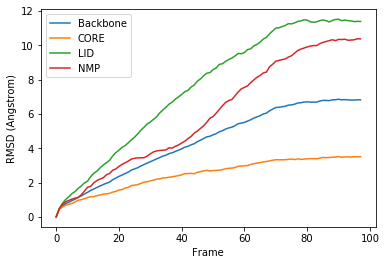

In [8]:
ax = df.plot(x='Frame', y=['Backbone', 'CORE', 'LID', 'NMP'],
             kind='line')
ax.set_ylabel('RMSD (Angstrom)')

## RMSD of an AtomGroup with multiple selections

The `RMSD` class accepts both `AtomGroup`s and `Universe`s as arguments. Restricting the atoms considered to an AtomGroup can be very helpful, as the `select` and `groupselections` arguments are applied only to the atoms in the original `AtomGroup`. In the example below, for example, only the alpha-carbons of the CORE domain are incorporated in the analysis.

<div class="alert alert-info">
    
**Note**

This feature does not currently support `groupselections`.

</div>

In [9]:
ca = u.select_atoms('name CA')

R = rms.RMSD(ca, ca, select=CORE, ref_frame=0)
R.run()

Text(0, 0.5, 'RMSD (Angstrom)')

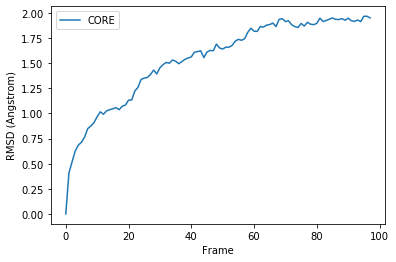

In [10]:
df = pd.DataFrame(R.rmsd, 
                  columns=['Frame', 'Time (ns)', 
                           'CORE'])

ax = df.plot(x='Frame', y='CORE', kind='line')
ax.set_ylabel('RMSD (Angstrom)')

## Weighted RMSD of a trajectory

You can also calculate the weighted RMSD of a trajectory using the `weights` and `weights_groupselections` keywords. The former only applies weights to the group in `select`, while the latter must be a list of the *same length and order* as `groupselections`. If you would like to only weight certain groups in `groupselections`, use `None` for the unweighted groups. Both `weights` and `weights_groupselections` accept `None` (for unweighted), `'mass'` (to weight by mass), and custom arrays. A custom array should have the same number of values as there are particles in the corresponding AtomGroup.

### Mass

It is common to weight RMSD analyses by particle weight, so the `RMSD` class accepts `'mass'` as an argument for `weights`. Note that the `weights` keyword only applies to the group in `select`, and does not apply to the `groupselections`; these remain unweighted below.

In [11]:
R_mass = rms.RMSD(u, u,
                  select='protein and name CA',
                  weights='mass',
                  groupselections=[CORE, LID, NMP])
R_mass.run()

The plot looks largely the same as above because all the alpha-carbons and individual backbone atoms have the same mass. Below we show how you can pass in custom weights.

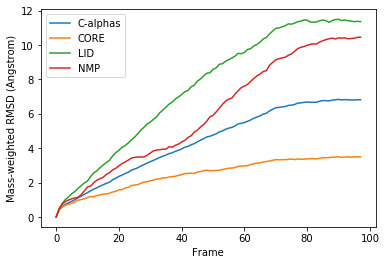

In [12]:
df_mass = pd.DataFrame(R_mass.rmsd, 
                       columns=['Frame', 
                                'Time (ns)', 
                                'C-alphas', 'CORE', 
                                'LID', 'NMP'])
ax_mass = df_mass.plot(x='Frame', 
                       y=['C-alphas', 'CORE', 'LID', 'NMP'])
ax_mass.set_ylabel('Mass-weighted RMSD (Angstrom)');

### Custom weights

You can also pass in an array of values for the weights. This must have the same length as the number of atoms in your selection groups. In this example, we pass in arrays of residue numbers. This **is not a typical weighting you might choose**, but we use it here to show how you can get different results to the previous graphs for mass-weighted and non-weighted RMSD. You could choose to pass in an array of charges, or your own custom value. 

First we select the atom groups to make this easier.

In [13]:
ag = u.select_atoms('protein and name CA')
print('Shape of C-alpha charges:', ag.charges.shape)
core = u.select_atoms(CORE)
lid = u.select_atoms(LID)
nmp = u.select_atoms(NMP)

Shape of C-alpha charges: (214,)


Below, we pass in weights for `ag` with the `weights` keyword, and weights for the `groupselections` with the `weights_groupselections` keyword.

In [14]:
R_charge = rms.RMSD(u, u,
                    select='protein and name CA',
                    groupselections=[CORE, LID, NMP],
                    weights=ag.resids,
                    weights_groupselections=[core.resids, 
                                             lid.resids, 
                                             nmp.resids])
R_charge.run()

You can see in the below graph that the NMP domain has much higher RMSD than before, as each particle is weighted by its residue number. Conversely, the CORE domain doesn't really change much. We could potentially infer from this that residues later in the NMP domain (with a higher residue number) are mobile during the length of the trajectory, whereas residues later in the CORE domain do not seem to contribute significantly to the RMSD.

However, again, this is a **very non-conventional metric** and is shown here simply to demonstrate how to use the code.

Text(0, 0.5, 'Charge-weighted RMSD (Angstrom)')

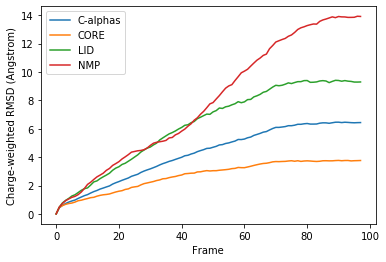

In [15]:
df_charge = pd.DataFrame(R_charge.rmsd, 
                         columns=['Frame', 
                                'Time (ns)', 
                                'C-alphas', 'CORE', 
                                'LID', 'NMP'])
ax_charge = df_charge.plot(x='Frame',
                           y=['C-alphas', 'CORE', 'LID', 'NMP'])
ax_charge.set_ylabel('Charge-weighted RMSD (Angstrom)')

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[4] Douglas&nbsp;L. Theobald.
Rapid calculation of <span class="bibtex-protected">RMSDs</span> using a quaternion-based characteristic polynomial.
<em>Acta Crystallographica Section A Foundations of Crystallography</em>, 61(4):478–480, July 2005.
00127.
URL: <a href="http://scripts.iucr.org/cgi-bin/paper?S0108767305015266">http://scripts.iucr.org/cgi-bin/paper?S0108767305015266</a>, <a href="https://doi.org/10.1107/S0108767305015266">doi:10.1107/S0108767305015266</a>.